## Siemens Bootstrap

**Index**

1. Loading the datasets
2. Transposing the time series datasets
3. Merging time series datasets to add additional features
4. Filtering and spliting in Blood and aqueous groups
5. Window extraction
6. Center the data based on "Align the start point"
  - Combine the Fluid Type of Sensor B
  - Visualize the center data
  - Merge the features with window(time series)
7. Functional PCA
  - Define boostrap function
  - Display the first component plot under 99% confidential level



# 1. Loading the datasets

In [174]:
!pip install scikit-fda

In [175]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import random
from sklearn.decomposition import PCA
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA
from sklearn.preprocessing import OneHotEncoder
import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis

# 2. Transposing the time series datasets

You can change this part based on where you store the data

In [176]:
# from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

# import datasets
path = "drive/MyDrive"
sensorA_System1 = pd.read_csv(path+"/System1_SensorA.csv")
sensorA_System2 = pd.read_csv(path+"/System2_SensorA.csv")
sensorB_System1 = pd.read_csv(path+"/System1_SensorB.csv")
sensorB_System2 = pd.read_csv(path+"/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv(path+"/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv(path+"/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv(path+"/Key by TestID.csv", parse_dates=['DateTime'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Merging time series datasets to add additional features

In [177]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [178]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [179]:
# Create new column to fill fluid temperature NA's
# Note: Fluid temperature: If specified, take as the temperature of the sample fluid. The rest of the system temperature can be taken as ambient temperature.

keyByTestID['Fluid_Temperature_Filled'] = keyByTestID['Fluid Temperature'].combine_first(keyByTestID['AmbientTemperature'])
keyByTestID.head(3)

,TestID,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode,Fluid_Temperature_Filled
0,3550995,Eurotrol L1,2024-02-07 10:32:15,16-23333-20,302910,70,73,180.4,178.8,System 2A,Sensor A,21.2345,NaN,NaN,Success,NoError,NoError,Success,21.2345
1,3550995,Eurotrol L1,2024-02-07 10:32:15,16-23333-20,302910,70,73,180.4,178.8,System 2A,Sensor B,21.2345,NaN,NaN,Success,NoError,NoError,Success,21.2345
2,3551012,Eurotrol L1,2024-02-07 10:41:33,16-23333-20,303096,70,73,183.2,181.6,System 2A,Sensor A,21.5012,NaN,NaN,Success,NoError,NoError,Success,21.5012


In [180]:
keyByTestID["System"] = keyByTestID["System"].replace({"System 2A":"System 2","System 2B":"System 2"})

In [181]:
keyByTestID.tail(3)

,TestID,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode,Fluid_Temperature_Filled
24255,3518677,HNB,2023-09-19 16:54:21,16-23151-20,302186,111,23,459.0,454.8,System 2,Sensor B,25.2250,15.0,NaN,Success,NoError,NoError,Success,15.0
24256,3518678,HNB,2023-09-19 16:54:23,16-23137-20,300820,125,33,459.2,455.2,System 2,Sensor A,24.4908,15.0,NaN,Success,NoError,NoError,Success,15.0
24257,3518678,HNB,2023-09-19 16:54:23,16-23137-20,300820,125,33,459.2,455.2,System 2,Sensor B,24.4908,15.0,NaN,Success,NoError,NoError,Success,15.0


In [182]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3377)
A2:  (7743, 3368)
B1:  (3375, 3377)
B2:  (7745, 3368)


# 4. Resampling the data by Fluid Type

In [183]:
# Remove the testID only exists in one system
# Only run once
A1_Merged = A1_Merged[A1_Merged["TestID"].isin(B1_Merged["TestID"])]
B1_Merged = B1_Merged[B1_Merged["TestID"].isin(A1_Merged["TestID"])]

A2_Merged = A2_Merged[A2_Merged["TestID"].isin(B2_Merged["TestID"])]
B2_Merged = B2_Merged[B2_Merged["TestID"].isin(A2_Merged["TestID"])]
print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3374, 3377)
A2:  (7743, 3368)
B1:  (3374, 3377)
B2:  (7743, 3368)


# 5. Window extraction

In [184]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Match window values of Sensor B for each test

# Blood
calDelLimit_sensorB_blood = 20
sampleDelLimit_sensorB_blood = 24
calWindowSize_sensorB_blood = 18
sampleWindowSize_sensorB_blood = 4

# Aqueous
calDelLimit_sensorB_aqueous = 20
sampleDelLimit_sensorB_aqueous = 30
calWindowSize_sensorB_aqueous = 18
sampleWindowSize_sensorB_aqueous = 4

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    """
    Calculate the start and end values for calibration and sample windows. The calculation is based on given start points and delimiters for both windows, as well as the window sizes.

    Parameters:
    -----------
    bubble_start : float
        The starting point for the bubble (reference point for calibration).
    sample_start : float
        The starting point for the sample.
    calDelimit_input : float
        The delimiter value to adjust the starting point of the calibration window.
    cal_window_size_input : float
        The size of the calibration window.
    sampleDelimit_input : float
        The delimiter value to adjust the starting point of the sample window.
    sample_window_size_input : float
        The size of the sample window.

    Returns:
    --------
    tuple of float
        A tuple containing four values:
        - cal_window_start: The starting position of the calibration window, rounded to one decimal place.
        - cal_window_end: The ending position of the calibration window, rounded to one decimal place.
        - sample_window_start: The starting position of the sample window, rounded to one decimal place.
        - sample_window_end: The ending position of the sample window, rounded to one decimal place.
    """
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return round(cal_window_start,1), round(cal_window_end,1), round(sample_window_start,1), round(sample_window_end,1)

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end

# Sensor B
# Blood

# Sensor B - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B1_blood_Merged['cal_window_start']=cal_window_start
B1_blood_Merged['cal_window_end']=cal_window_end
B1_blood_Merged['sample_window_start']=sample_window_start
B1_blood_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B2_blood_Merged['cal_window_start']=cal_window_start
B2_blood_Merged['cal_window_end']=cal_window_end
B2_blood_Merged['sample_window_start']=sample_window_start
B2_blood_Merged['sample_window_end']=sample_window_end


# Sensor B - aqueous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B1_aqueous_Merged['cal_window_start']=cal_window_start
B1_aqueous_Merged['cal_window_end']=cal_window_end
B1_aqueous_Merged['sample_window_start']=sample_window_start
B1_aqueous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B2_aqueous_Merged['cal_window_start']=cal_window_start
B2_aqueous_Merged['cal_window_end']=cal_window_end
B2_aqueous_Merged['sample_window_start']=sample_window_start
B2_aqueous_Merged['sample_window_end']=sample_window_end

In [185]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    """
    Extracts calibration and sample window data from a given row of time series data.

    Parameters:
    row (pd.Series): A pandas Series object containing time series data and window start/end times.
        The Series should have the following structure:
        - 'cal_window_start': The start time for the calibration window.
        - 'cal_window_end': The end time for the calibration window.
        - 'sample_window_start': The start time for the sample window.
        - 'sample_window_end': The end time for the sample window.
        - The index from position 19 to -4 should contain the timestamps (as float) of the time series data.

    Returns:
    tuple: A tuple containing two pandas Series:
        - The first Series corresponds to the data within the calibration window.
        - The second Series corresponds to the data within the sample window.
    """
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[19:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID'].astype(int)
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID'].astype(int)
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Blood

B1_blood_cal_window = []
B1_blood_sample_window = []
for i in range(len(B1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B1_blood_Merged.iloc[i, :])
    B1_blood_cal_window.append(cal_window.values)
    B1_blood_sample_window.append(sample_window.values)
B1_blood_cal_window = pd.DataFrame(B1_blood_cal_window)
B1_blood_sample_window = pd.DataFrame(B1_blood_sample_window)
B1_blood_cal_window['TestID'] = B1_blood_sample_window['TestID'] = B1_blood_Merged['TestID'].astype(int)
B1_blood_sample_window.set_index('TestID',inplace=True)
B1_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B - Blood

B2_blood_cal_window = []
B2_blood_sample_window = []
for i in range(len(B2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B2_blood_Merged.iloc[i, :])
    B2_blood_cal_window.append(cal_window.values)
    B2_blood_sample_window.append(sample_window.values)
B2_blood_cal_window = pd.DataFrame(B2_blood_cal_window)
B2_blood_sample_window = pd.DataFrame(B2_blood_sample_window)
B2_blood_cal_window['TestID'] = B2_blood_sample_window['TestID'] = B2_blood_Merged['TestID'].astype(int)
B2_blood_sample_window.set_index('TestID',inplace=True)
B2_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - aqueous

B1_aqueous_cal_window = []
B1_aqueous_sample_window = []
for i in range(len(B1_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(B1_aqueous_Merged.iloc[i, :])
    B1_aqueous_cal_window.append(cal_window.values)
    B1_aqueous_sample_window.append(sample_window.values)
B1_aqueous_cal_window = pd.DataFrame(B1_aqueous_cal_window)
B1_aqueous_sample_window = pd.DataFrame(B1_aqueous_sample_window)
B1_aqueous_cal_window['TestID'] = B1_aqueous_sample_window['TestID'] = B1_aqueous_Merged['TestID'].astype(int)
B1_aqueous_sample_window.set_index('TestID',inplace=True)
B1_aqueous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aqueous

B2_aqueous_cal_window = []
B2_aqueous_sample_window = []
for i in range(len(B2_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(B2_aqueous_Merged.iloc[i, :])
    B2_aqueous_cal_window.append(cal_window.values)
    B2_aqueous_sample_window.append(sample_window.values)
B2_aqueous_cal_window = pd.DataFrame(B2_aqueous_cal_window)
B2_aqueous_sample_window = pd.DataFrame(B2_aqueous_sample_window)
B2_aqueous_cal_window['TestID'] = B2_aqueous_sample_window['TestID'] = B2_aqueous_Merged['TestID'].astype(int)
B2_aqueous_sample_window.set_index('TestID',inplace=True)
B2_aqueous_cal_window.set_index('TestID',inplace=True)

## 5.1. Validating if there are partial or full missing values after the extraction

In [186]:
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

B1_blood_cal_window_drop_index = B1_blood_cal_window.loc[B1_blood_cal_window.isna().sum(axis=1)!=0].index
B1_aqueous_cal_window_drop_index = B1_aqueous_cal_window.loc[B1_aqueous_cal_window.isna().sum(axis=1)!=0].index
B2_blood_cal_window_drop_index = B2_blood_cal_window.loc[B2_blood_cal_window.isna().sum(axis=1)!=0].index
B2_aqueous_cal_window_drop_index = B2_aqueous_cal_window.loc[B2_aqueous_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index


B1_blood_sample_window_drop_index = B1_blood_sample_window.loc[B1_blood_sample_window.isna().sum(axis=1)!=0].index
B1_aqueous_sample_window_drop_index = B1_aqueous_sample_window.loc[B1_aqueous_sample_window.isna().sum(axis=1)!=0].index
B2_blood_sample_window_drop_index = B2_blood_sample_window.loc[B2_blood_sample_window.isna().sum(axis=1)!=0].index
B2_aqueous_sample_window_drop_index = B2_aqueous_sample_window.loc[B2_aqueous_sample_window.isna().sum(axis=1)!=0].index

# Check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",A2_sample_window_drop_index)

print("The missing value in calibration window:",B1_blood_cal_window_drop_index)
print("The missing value in sample window:",B1_blood_sample_window_drop_index)
print("The missing value in calibration window:",B2_blood_cal_window_drop_index)
print("The missing value in sample window:",B2_blood_sample_window_drop_index)

The missing value in calibration window: Index([], dtype='float64', name='TestID')
The missing value in sample window: Index([], dtype='float64', name='TestID')
The missing value in calibration window: Index([], dtype='int64', name='TestID')
The missing value in sample window: Index([], dtype='int64', name='TestID')
The missing value in calibration window: Index([], dtype='int64', name='TestID')
The missing value in sample window: Index([], dtype='int64', name='TestID')
The missing value in calibration window: Index([], dtype='int64', name='TestID')
The missing value in sample window: Index([], dtype='int64', name='TestID')


# 6. Center the data

In [187]:
A1_cal_window_zero = A1_cal_window.iloc[:, 1:].sub(A1_cal_window.iloc[:, 1], axis=0)
# A1_blood_cal_window_zero = A1_blood_cal_window.iloc[:, 1:].sub(A1_blood_cal_window.iloc[:, 1], axis=0)
# A1_aqueous_cal_window_zero = A1_aqueous_cal_window.iloc[:, 1:].sub(A1_aqueous_cal_window.iloc[:, 1], axis=0)
B1_blood_cal_window_zero = B1_blood_cal_window.iloc[:, 1:].sub(B1_blood_cal_window.iloc[:, 1], axis=0)
B1_aqueous_cal_window_zero = B1_aqueous_cal_window.iloc[:, 1:].sub(B1_aqueous_cal_window.iloc[:, 1], axis=0)
A2_cal_window_zero = A2_cal_window.iloc[:, 1:].sub(A2_cal_window.iloc[:, 1], axis=0)
# A2_blood_cal_window_zero = A2_blood_cal_window.iloc[:, 1:].sub(A2_blood_cal_window.iloc[:, 1], axis=0)
# A2_aqueous_cal_window_zero = A2_aqueous_cal_window.iloc[:, 1:].sub(A2_aqueous_cal_window.iloc[:, 1], axis=0)
B2_blood_cal_window_zero = B2_blood_cal_window.iloc[:, 1:].sub(B2_blood_cal_window.iloc[:, 1], axis=0)
B2_aqueous_cal_window_zero = B2_aqueous_cal_window.iloc[:, 1:].sub(B2_aqueous_cal_window.iloc[:, 1], axis=0)


A1_sample_window_zero = A1_sample_window.iloc[:, 1:].sub(A1_sample_window.iloc[:, 1], axis=0)
# A1_blood_sample_window_zero = A1_blood_sample_window.iloc[:, 1:].sub(A1_blood_sample_window.iloc[:, 1], axis=0)
# A1_aqueous_sample_window_zero = A1_aqueous_sample_window.iloc[:, 1:].sub(A1_aqueous_sample_window.iloc[:, 1], axis=0)
B1_blood_sample_window_zero = B1_blood_sample_window.iloc[:, 1:].sub(B1_blood_sample_window.iloc[:, 1], axis=0)
B1_aqueous_sample_window_zero = B1_aqueous_sample_window.iloc[:, 1:].sub(B1_aqueous_sample_window.iloc[:, 1], axis=0)
A2_sample_window_zero = A2_sample_window.iloc[:, 1:].sub(A2_sample_window.iloc[:, 1], axis=0)
# A2_blood_sample_window_zero = A2_blood_sample_window.iloc[:, 1:].sub(A2_blood_sample_window.iloc[:, 1], axis=0)
# A2_aqueous_sample_window_zero = A2_aqueous_sample_window.iloc[:, 1:].sub(A2_aqueous_sample_window.iloc[:, 1], axis=0)
B2_blood_sample_window_zero = B2_blood_sample_window.iloc[:, 1:].sub(B2_blood_sample_window.iloc[:, 1], axis=0)
B2_aqueous_sample_window_zero = B2_aqueous_sample_window.iloc[:, 1:].sub(B2_aqueous_sample_window.iloc[:, 1], axis=0)

# B1_cal_window_zero = B1_cal_window.iloc[:, 1:].sub(B1_cal_window.iloc[:, 1], axis=0)
# B1_sample_window_zero = B1_sample_window.iloc[:, 1:].sub(B1_sample_window.iloc[:, 1], axis=0)

In [188]:
B1_cal_window_zero = pd.concat([B1_blood_cal_window_zero, B1_aqueous_cal_window_zero], axis=0)
B1_cal_window_zero = B1_cal_window_zero.reindex(A1_cal_window_zero.index)
B2_cal_window_zero = pd.concat([B2_blood_cal_window_zero, B2_aqueous_cal_window_zero], axis=0)
B2_cal_window_zero = B2_cal_window_zero.reindex(A2_cal_window_zero.index)

B1_sample_window_zero = pd.concat([B1_blood_sample_window_zero, B1_aqueous_sample_window_zero], axis=0)
B1_sample_window_zero = B1_sample_window_zero.reindex(A1_sample_window_zero.index)
B2_sample_window_zero = pd.concat([B2_blood_sample_window_zero, B2_aqueous_sample_window_zero], axis=0)
B2_sample_window_zero = B2_sample_window_zero.reindex(A2_sample_window_zero.index)

In [189]:
print(A1_cal_window_zero.shape)
print(A2_cal_window_zero.shape)
print(A1_sample_window_zero.shape)
print(A2_sample_window_zero.shape)


print(B1_cal_window_zero.shape)
print(B2_cal_window_zero.shape)
print(B1_sample_window_zero.shape)
print(B2_sample_window_zero.shape)




(3374, 40)
(7743, 40)
(3374, 25)
(7743, 25)
(3374, 90)
(7743, 90)
(3374, 20)
(7743, 20)


## Visualize

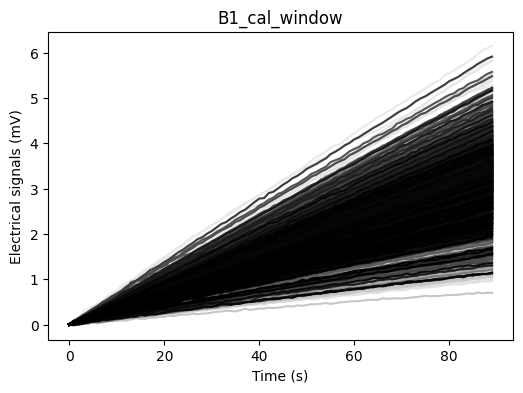

In [190]:
def plot_all_time_series(df, title):
    """
    Plots all time series data from a DataFrame.

    Parameters:
    df (pd.DataFrame): A pandas DataFrame where each row represents a time series. The values in the rows are the
                       data points of the time series.
    title (str): The title for the plot.

    Returns:
    Display the chart with all the time series in one plot.
    """
    plt.figure(figsize=(6, 4))

    # Generate colors using a colormap
    num_lines = len(df)
    colors = plt.cm.Greys(np.linspace(0, 1, num_lines))

    # Plot each row with a different color
    for index, (i, row) in enumerate(df.iterrows()):
        plt.plot(row.values, label=f'Time Series {i + 1}', color=colors[index])

    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.show()
plot_all_time_series(B1_cal_window_zero, "B1_cal_window")


## Merge Data

In [191]:
def Merge_data(windows, merge_data):
    """
    Merge the 'windows' dataframe with selected columns from the 'merge' dataframe,
    categorize 'AgeOfCardInDaysAtTimeOfTest' and 'AmbientTemperature' into bins,
    and return a random sample of the combined dataframe.

    Parameters:
    windows (DataFrame): The primary dataframe to merge.
    merge (DataFrame): The dataframe containing the additional columns to merge.

    Returns:
    DataFrame: A random sample of 500 rows from the merged dataframe.
    """

    # Merge the two dataframes on their indices
    window_combine = windows.merge(
        merge_data[["FluidType", "AgeOfCardInDaysAtTimeOfTest", "AmbientTemperature","Fluid_Temperature_Filled"]],
        how="inner",
        left_index=True,
        right_index=True
    )

    # Categorize 'AgeOfCardInDaysAtTimeOfTest' into bins
    window_combine["AgeOfCardInDaysAtTimeOfTest"] = pd.cut(
        window_combine["AgeOfCardInDaysAtTimeOfTest"],
        bins=[0, 9, 28, 56, 84, 112, 140, 168, 196, 224, 252],
        labels=['Below 9', '9-28', '28-56', '56-84', '84-112', '112-140', '140-168', '168-196', '196-224', '224-252']
    )

    # Categorize 'AmbientTemperature' into bins
    window_combine["AmbientTemperature"] = pd.cut(
        window_combine["AmbientTemperature"],
        bins=[-1, 20, 25, 100],
        labels=['Below 20', '20-25', 'Above 25']
    )

    # Categorize 'Fluid_Temperature_Filled' into bins
    window_combine["Fluid_Temperature_Filled"] = pd.cut(
        window_combine["Fluid_Temperature_Filled"],
        bins=[-1, 20, 25, 100],
        labels=['Below 20', '20-25', 'Above 25']
    )

    return window_combine


In [192]:
# Set index for Merge datasets
A1_Merged.set_index("TestID", inplace=True)
A2_Merged.set_index("TestID", inplace=True)

# A1_blood_Merged.set_index("TestID", inplace=True)
# A2_blood_Merged.set_index("TestID", inplace=True)
# A1_aqueous_Merged.set_index("TestID", inplace=True)
# A2_aqueous_Merged.set_index("TestID", inplace=True)

B1_Merged.set_index("TestID", inplace=True)
B2_Merged.set_index("TestID", inplace=True)


# B1_blood_Merged.set_index("TestID", inplace=True)
# B2_blood_Merged.set_index("TestID", inplace=True)
# B1_aqueous_Merged.set_index("TestID", inplace=True)
# B2_aqueous_Merged.set_index("TestID", inplace=True)

In [193]:
# Combine data
A1_cal_window_combine = Merge_data(A1_cal_window_zero,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window_zero,A2_Merged)
# A1_blood_cal_window_combine = Merge_data(A1_blood_cal_window_zero,A1_blood_Merged)
# A2_blood_cal_window_combine = Merge_data(A2_blood_cal_window_zero,A2_blood_Merged)
# A1_aqueous_cal_window_combine = Merge_data(A1_aqueous_cal_window_zero,A1_aqueous_Merged)
# A2_aqueous_cal_window_combine = Merge_data(A2_aqueous_cal_window_zero,A2_aqueous_Merged)

B1_cal_window_combine = Merge_data(B1_cal_window_zero,B1_Merged)
B2_cal_window_combine = Merge_data(B2_cal_window_zero,B2_Merged)
# B1_blood_cal_window_combine = Merge_data(B1_blood_cal_window_zero,B1_blood_Merged)
# B2_blood_cal_window_combine = Merge_data(B2_blood_cal_window_zero,B2_blood_Merged)
# B1_aqueous_cal_window_combine = Merge_data(B1_aqueous_cal_window_zero,B1_aqueous_Merged)
# B2_aqueous_cal_window_combine = Merge_data(B2_aqueous_cal_window_zero,B2_aqueous_Merged)

## Sample window
A1_sample_window_combine = Merge_data(A1_sample_window_zero,A1_Merged)
A2_sample_window_combine = Merge_data(A2_sample_window_zero,A2_Merged)
# A1_blood_sample_window_combine = Merge_data(A1_blood_sample_window_zero,A1_blood_Merged)
# A2_blood_sample_window_combine = Merge_data(A2_blood_sample_window_zero,A2_blood_Merged)
# A1_aqueous_sample_window_combine = Merge_data(A1_aqueous_sample_window_zero,A1_aqueous_Merged)
# A2_aqueous_sample_window_combine = Merge_data(A2_aqueous_sample_window_zero,A2_aqueous_Merged)

B1_sample_window_combine = Merge_data(B1_sample_window_zero,B1_Merged)
B2_sample_window_combine = Merge_data(B2_sample_window_zero,B2_Merged)
# B1_blood_sample_window_combine = Merge_data(B1_blood_sample_window_zero,B1_blood_Merged)
# B2_blood_sample_window_combine = Merge_data(B2_blood_sample_window_zero,B2_blood_Merged)
# B1_aqueous_sample_window_combine = Merge_data(B1_aqueous_sample_window_zero,B1_aqueous_Merged)
# B2_aqueous_sample_window_combine = Merge_data(B2_aqueous_sample_window_zero,B2_aqueous_Merged)


# 7. FPCA

In [194]:
A1_Merged.Fluid_Temperature_Filled

TestID
12414200    20.9253
12414201    21.1005
12414202    20.9240
12414203    20.9240
12414204    20.9199
             ...   
12470361    21.1863
12470365    20.8406
12537663    21.9274
12539049    22.6098
12622570    21.6424
Name: Fluid_Temperature_Filled, Length: 3374, dtype: float64

In [195]:
def fpca_two_inputs(time_series_s1, time_series_s2, y_axis_min=None, y_axis_max=None):
    """
    Performs Functional Principal Component Analysis (FPCA) on two sets of time series data from different systems
    and plots the first principal component for both systems on the same graph.

    Parameters:
    time_series_s1 (pd.DataFrame): A pandas DataFrame representing time series data from System 1. Each row represents
                                   a time series and each column represents a time point.
    time_series_s2 (pd.DataFrame): A pandas DataFrame representing time series data from System 2. Each row represents
                                   a time series and each column represents a time point.
    y_axis_min (float, optional): The minimum value for the y-axis in the plot. Defaults to None.
    y_axis_max (float, optional): The maximum value for the y-axis in the plot. Defaults to None.

    Returns:
    tuple: A tuple containing two pandas DataFrames representing the functional principal component scores for System 1
           and System 2 respectively.

    Prints:
    - The explained variance ratio of the first principal component for both systems.
    - The functional principal component scores for each time series in both systems.
    - Plots the first principal component for both systems on the same graph.

    """
    # Convert the data matrix to an FDataGrid object
    fd_s1 = FDataGrid(data_matrix=time_series_s1, grid_points=time_series_s1.columns.astype(float)) # System 1
    fd_s2 = FDataGrid(data_matrix=time_series_s2, grid_points=time_series_s2.columns.astype(float)) # System 2

    # Apply Functional PCA for System 1
    fpca_s1 = FPCA(n_components=2, centering=False)
    fpca_s1.fit(fd_s1)
    fpc_and_scores_s1 = fpca_s1.transform(fd_s1)

    # Apply Functional PCA for System 2
    fpca_s2 = FPCA(n_components=2, centering=False)
    fpca_s2.fit(fd_s2)
    fpc_and_scores_s2 = fpca_s2.transform(fd_s2)

    return fpca_s1.components_[0],fpca_s2.components_[0]

In [226]:
def bootstrap(system1_data, system2_data,sensor,window,features="AmbientTemperature",randomness=100):
  fpca_s1_list = []
  fpca_s2_list = []
  Resample_Value1 = system1_data[features].value_counts().min()
  Resample_Value2 = system2_data[features].value_counts().min()
  Resample_Value = min(Resample_Value1,Resample_Value2)

  for i in range(0,randomness):
    Id1 = system1_data.groupby(features, group_keys=False).apply(lambda x: x.sample(Resample_Value,random_state=i)).index
    Id2 = system2_data.groupby(features, group_keys=False).apply(lambda x: x.sample(Resample_Value,random_state=i)).index
    Resample_data1 = system1_data.loc[Id1,:].iloc[:,:-4]
    Resample_data2 = system2_data.loc[Id2,:].iloc[:,:-4]
    fpca_s1, fpca_s2 = fpca_two_inputs(Resample_data1, Resample_data2)
    fpca_s1_list.append(fpca_s1.data_matrix[0].flatten())
    fpca_s2_list.append(fpca_s2.data_matrix[0].flatten())

  upper1 = np.percentile(fpca_s1_list, 95, axis=0)
  lower1 = np.percentile(fpca_s1_list, 5, axis=0)
  x1 = np.arange(len(upper1))

  upper2 = np.percentile(fpca_s2_list, 95, axis=0)
  lower2 = np.percentile(fpca_s2_list, 5, axis=0)
  x2 = np.arange(len(upper2))

  plt.plot(x1,fpca_s1_list[20], color='orange', linewidth=1, label='System 1')
  plt.fill_between(x1, lower1, upper1, color='orange', alpha=0.2, label='95% Confidence Interval 1')

  plt.plot(x2, fpca_s2_list[20], color='blue', linewidth=1, label='System 2')
  plt.fill_between(x2, lower2, upper2, color='blue', alpha=0.1, label='95% Confidence Interval 2')

  plt.xlabel('Time')
  plt.ylabel('Functional PC 1 Values')
  plt.title("System 1 versus System 2 in {} {}".format(sensor, window))
  plt.legend()
  plt.show()
  return fpca_s1_list,fpca_s1_list

### Fluid_Temperature_Filled

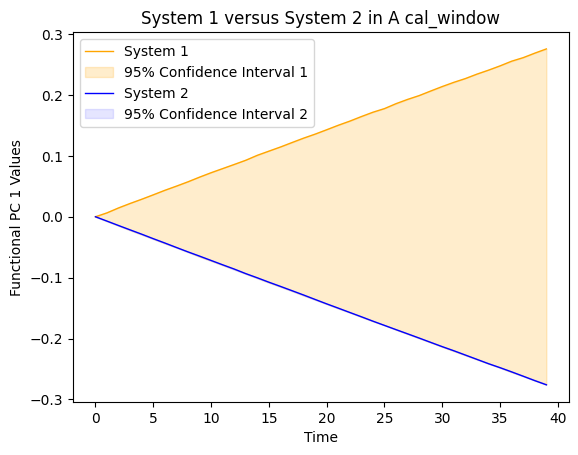

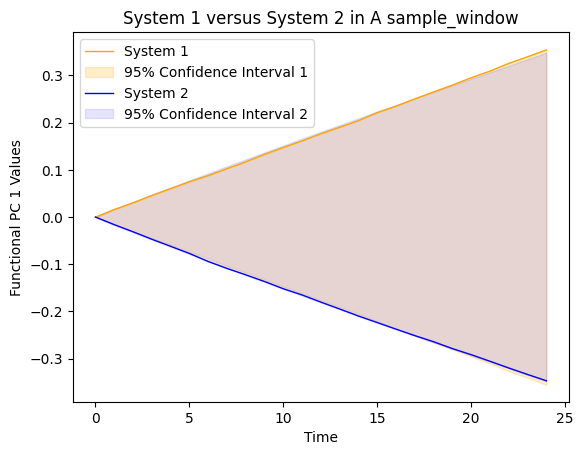

In [227]:
ac1,ac2 = bootstrap(A1_cal_window_combine,A2_cal_window_combine ,"A","cal_window",features="Fluid_Temperature_Filled")
as1,as2 = bootstrap(A1_sample_window_combine,A2_sample_window_combine,"A","sample_window",features="Fluid_Temperature_Filled")

### Ambient_Temperature

In [228]:
A1_cal_window_combine["Fluid_Temperature_Filled"].value_counts()

Fluid_Temperature_Filled
20-25       3208
Above 25      88
Below 20      72
Name: count, dtype: int64

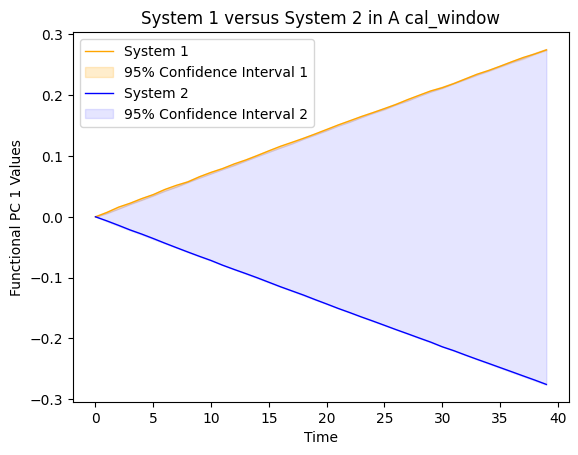

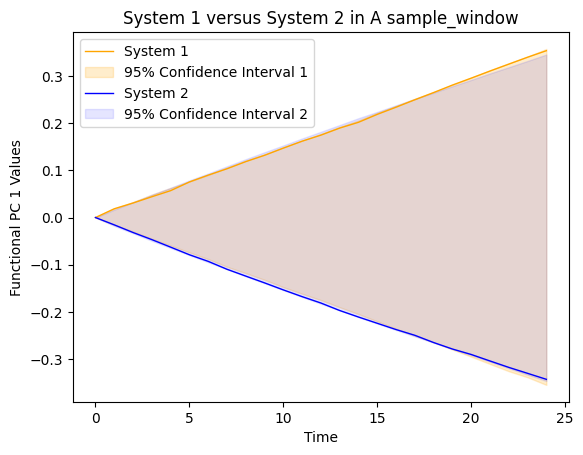

In [229]:
ac1,ac2 = bootstrap(A1_cal_window_combine,A2_cal_window_combine,"A","cal_window","AmbientTemperature")
as1,as2 = bootstrap(A1_sample_window_combine,A2_sample_window_combine,"A","sample_window","AmbientTemperature")

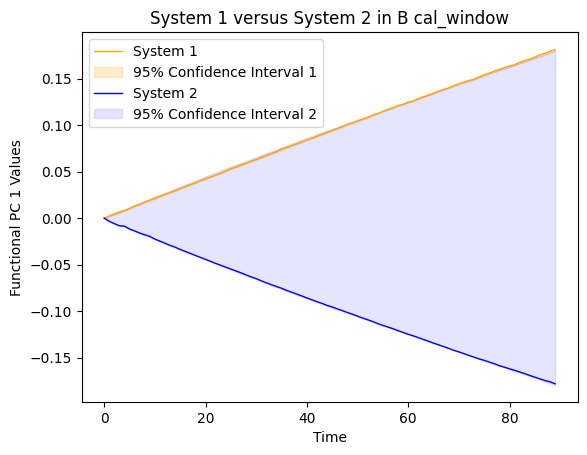

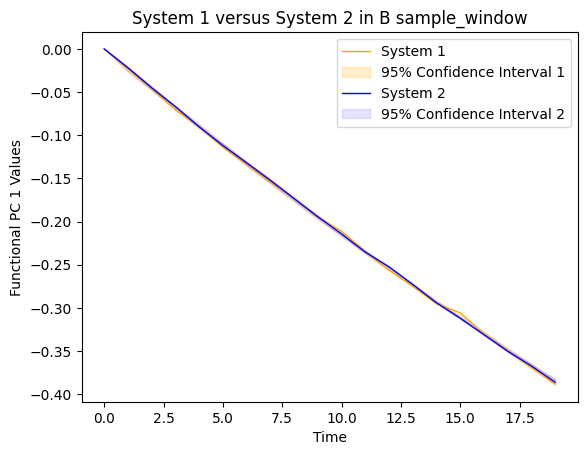

In [230]:
bc1,bc2 = bootstrap(B1_cal_window_combine,B2_cal_window_combine,"B","cal_window")
bs1,bs2 = bootstrap(B1_sample_window_combine,B2_sample_window_combine,"B","sample_window")

### Card Age

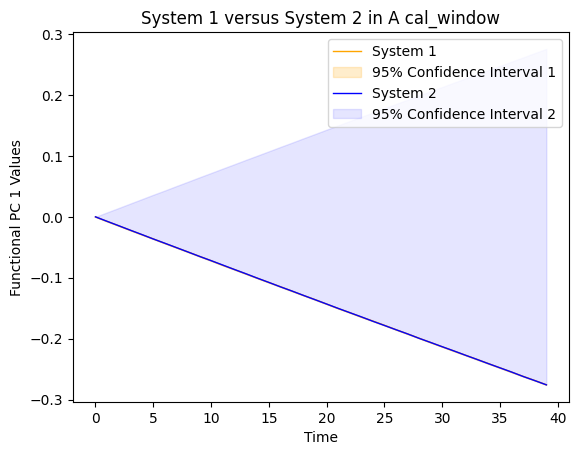

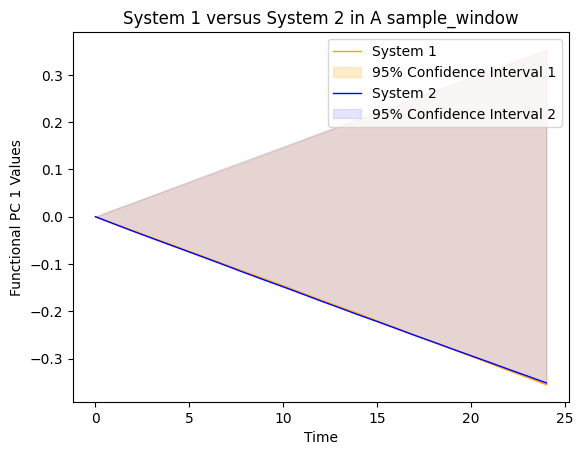

In [231]:
ac1,ac2 = bootstrap(A1_cal_window_combine,A2_cal_window_combine ,"A","cal_window","AgeOfCardInDaysAtTimeOfTest")
as1,as2 = bootstrap(A1_sample_window_combine,A2_sample_window_combine,"A","sample_window","AgeOfCardInDaysAtTimeOfTest")

### Fluid Type

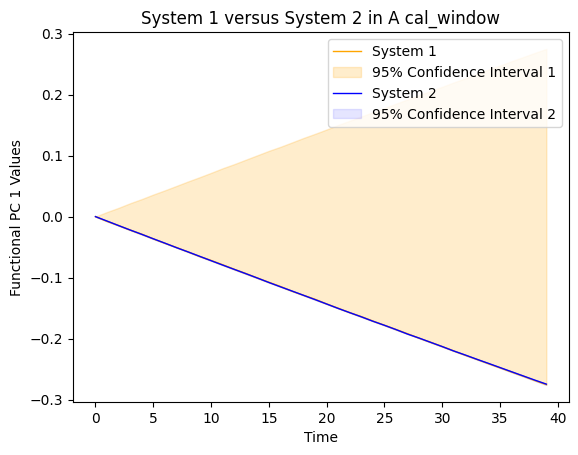

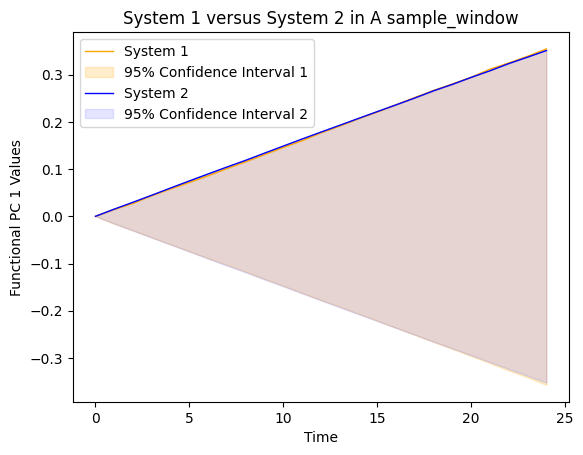

In [232]:
ac1,ac2 = bootstrap(A1_cal_window_combine,A2_cal_window_combine ,"A","cal_window","FluidType")
as1,as2 = bootstrap(A1_sample_window_combine,A2_sample_window_combine,"A","sample_window","FluidType")

# Different groups comparasion

In [239]:
def innergroup_bootstrap(group1,group2,sensor,window, randomness=100):
    fpca_s1_list = []
    fpca_s2_list = []

    for i in range(randomness):
        Resample_data1 = group1.iloc[:, :-4].sample(min(len(group1), len(group2), 30), random_state=i)
        Resample_data2 = group2.iloc[:, :-4].sample(min(len(group1), len(group2), 30), random_state=i)
        fpca_s1, fpca_s2 = fpca_two_inputs(Resample_data1, Resample_data2)
        fpca_s1_list.append(fpca_s1.data_matrix[0].flatten())
        fpca_s2_list.append(fpca_s2.data_matrix[0].flatten())

    upper1 = np.percentile(fpca_s1_list, 95, axis=0)
    lower1 = np.percentile(fpca_s1_list, 5, axis=0)
    x1 = np.arange(len(upper1))

    upper2 = np.percentile(fpca_s2_list, 95, axis=0)
    lower2 = np.percentile(fpca_s2_list, 5, axis=0)
    x2 = np.arange(len(upper2))

    plt.plot(x1,fpca_s1_list[20], color='orange', linewidth=1, label='Below 9 days')
    plt.fill_between(x1, lower1, upper1, color='orange', alpha=0.2, label='95% Confidence Interval 1')

    plt.plot(x2, fpca_s2_list[20], color='blue', linewidth=1, label='Upper 9 days')
    plt.fill_between(x2, lower2, upper2, color='blue', alpha=0.1, label='95% Confidence Interval 2')

    plt.xlabel('Time')
    plt.ylabel('Functional PC 1 Values')
    plt.title("Group 1 versus Group 2 in {} {}".format(sensor, window))
    plt.legend()
    plt.show()
    return fpca_s1_list,fpca_s1_list


### For Card age

In [240]:
A1_cal_window_combine_agebelow = A1_cal_window_combine.query("AgeOfCardInDaysAtTimeOfTest == 'Below 9'")
A1_cal_window_combine_agecommon = A1_cal_window_combine.query("~(AgeOfCardInDaysAtTimeOfTest.astype('str') == 'Below 9')")

A1_sample_window_combine_agebelow = A1_sample_window_combine.query("AgeOfCardInDaysAtTimeOfTest == 'Below 9'")
A1_sample_window_combine_agecommon = A1_sample_window_combine.query("~(AgeOfCardInDaysAtTimeOfTest.astype('str') == 'Below 9')")

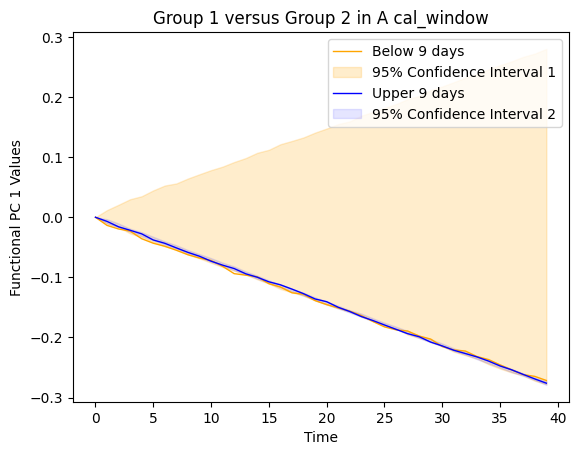

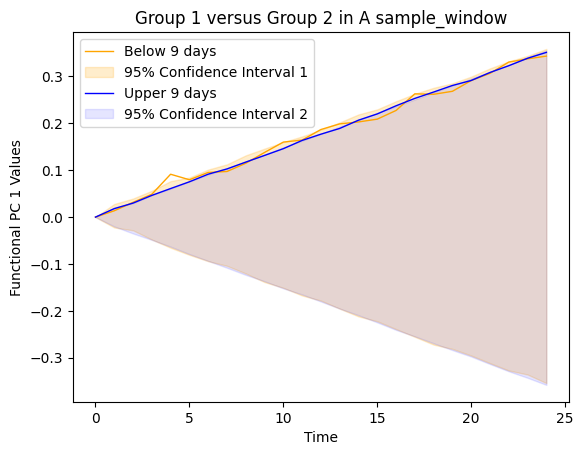

In [241]:
_,_ = innergroup_bootstrap(A1_cal_window_combine_agebelow,A1_cal_window_combine_agecommon ,"A","cal_window")
_,_ = innergroup_bootstrap(A1_sample_window_combine_agebelow,A1_sample_window_combine_agecommon,"A","sample_window")